In [7]:
%matplotlib notebook
from ..data_formatting_examples import format_local_Allen_data as flad
from  importlib import reload

import argparse
import io
import json
import os
import glob
import re
import zipfile,time
from typing import Mapping, Tuple, Union

import numpy as np
import requests
from skimage.io import imread
from slicedimage import ImageFormat

from starfish import Codebook
from starfish.experiment.builder import FetchedTile, TileFetcher
from starfish.experiment.builder import write_experiment_json
from starfish.types import Coordinates, Features, Indices, Number
from starfish.util.argparse import FsExistsType



import matplotlib.pyplot as plt
import numpy as np
import os,json

from starfish import data, FieldOfView
from starfish.types import Indices
from starfish import Experiment
from importlib import reload

from starfish.spots import SpotFinder
from starfish.image import Filter
import starfish.plot

SHAPE = 2048, 2048
PIXEL_SIZE = 1e-7
Z_SPACING = 3e-7
TC_STRING = "TileConfig_405.txt"
CH_STRINGS = ["Bandpass405", "Bandpass488", "Bandpass561", "Bandpass640"]


reload(flad)

ValueError: attempted relative import beyond top-level package

In [2]:
experiment = Experiment.from_json("/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/Allen_Mouse_Panel_1/experiment.json")


In [3]:
# create the runnables for the pipeline, using in_place = False for the 
# first pipeline so the original data can still be looked at. This should be ok on a workstation
# since it should be reset for each fov

kwargs = dict(
    spot_diameter=5, # must be odd integer
    min_mass=0.02,
    max_size=2,  # this is max _radius_
    separation=7,
    noise_size=0.65,  # this is not used because preprocess is False
    preprocess=False,
    percentile=10,  # this is irrelevant when min_mass, spot_diameter, and max_size are set properly
    verbose=True,
    is_volume=True,
)
tlmpf = SpotFinder.TrackpyLocalMaxPeakFinder(**kwargs)
bandpass = Filter.Bandpass(lshort=.5, llong=7, threshold=0.0)
sigma=(1, 0, 0)  # filter only in z, do nothing in x, y
glp = Filter.GaussianLowPass(sigma=sigma, is_volume=True)
clip1 = Filter.Clip(p_min=50, p_max=100)
clip2 = Filter.Clip(p_min=99, p_max=100, is_volume=True)

def allen_pipeline(fov, codebook):
    primary_image = fov[FieldOfView.PRIMARY_IMAGES]
    new_image = clip1.run(primary_image, verbose=True, in_place=False, n_processes = 7)
    bandpass.run(new_image, verbose=True, in_place=True, n_processes = 7)
    glp.run(new_image, in_place=True, verbose=True, n_processes = 7)
    clip2.run(new_image, verbose=True, in_place=True, n_processes = 7)
    spot_attributes = tlmpf.run(new_image)
    decoded = codebook.decode_per_round_max(spot_attributes)
    return decoded[decoded["total_intensity"]>.025]


# process all the fields of view, not just one
def process_experiment_allen(experiment: Experiment):
    decoded_intensities = []
    for i, (name_, fov) in enumerate(experiment.items()):
        try:
            decoded = allen_pipeline(fov, experiment.codebook)
            decoded_intensities.append({"name":name_,"decoded": decoded})
        except:
            print("pipeline failed for fov "+name_)
            decoded_intensities.append({"name":name_,"decoded": None})
    return decoded_intensities



In [4]:
#decoded_intensities = process_experiment_allen(experiment)
# trying to run this outside the function so I can get partial results
# started at
print(time.asctime())
decoded_intensities = []
for i, (name_, fov) in enumerate(experiment.items()):
#     try:
    if i >2:
        continue
    decoded = allen_pipeline(fov, experiment.codebook)
    decoded_intensities.append({"name":name_,"decoded": decoded})
    print("finished tile "+name_+" at "+str(time.asctime()))
#     except:
#         print("pipeline failed for fov "+name_)
#         decoded_intensities.append({"name":name_,"decoded": None})

Mon Jan  7 13:12:38 2019


100%|██████████| 918/918 [02:38<00:00,  6.08it/s]
918it [00:13, 69.46it/s]
27it [00:00, 538.62it/s]
27it [00:00, 502.65it/s]
/home/brianl/anaconda3/envs/starfishpy36/lib/python3.6/site-packages/trackpy/feature.py:418: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
/home/brianl/anaconda3/envs/starfishpy36/lib/python3.6/site-packages/trackpy/feature.py:418: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
/home/brianl/anacon

finished tile fov_000 at Mon Jan  7 13:20:06 2019


100%|██████████| 918/918 [02:44<00:00,  5.93it/s]
918it [00:10, 88.03it/s]
27it [00:00, 461.33it/s]
27it [00:00, 471.03it/s]


finished tile fov_001 at Mon Jan  7 13:27:00 2019


100%|██████████| 918/918 [02:39<00:00,  7.37it/s]
918it [00:09, 92.61it/s] 
27it [00:00, 616.86it/s]
27it [00:00, 676.48it/s]


finished tile fov_002 at Mon Jan  7 13:33:58 2019


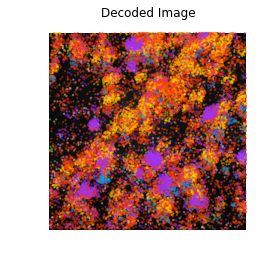

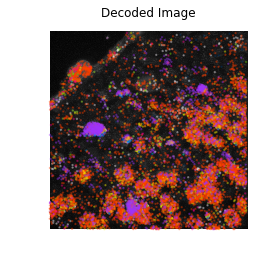

In [8]:
for ii,dfov in enumerate(decoded_intensities[0:3]):
    projection = experiment.fovs()[ii][FieldOfView.PRIMARY_IMAGES].max_proj(Indices.Z, Indices.ROUND)
    f=plt.figure()
    ax  =plt.gca()
    d = dfov["decoded"]
    starfish.plot.decoded_spots(d[d["total_intensity"]>.025], background_image=projection[1], ax=ax, spots_kwargs={'alpha': 0.3, 'cmap': plt.cm.gist_ncar})

In [20]:
for f in decoded_intensities:    
    f["decoded"].save_mermaid("/home/brianl/mFISHrig2/rexp1_acq4_data/Mouse_smFISH/CZI_test_output/"+
                              f["name"]+"_mermaid.csv.gz")
    f["decoded"].save("/home/brianl/mFISHrig2/rexp1_acq4_data/Mouse_smFISH/CZI_test_output/"+
                              f["name"]+".ncdf")

In [92]:
it0 = starfish.IntensityTable.load("/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_test_output/fov_050.ncdf")
it1 = starfish.IntensityTable.load("/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_test_output/fov_051.ncdf")


In [93]:
from starfish.intensity_table.intensity_table_coordinates import transfer_physical_coords_from_imagestack_to_intensity_table as tpc


In [165]:
f0=experiment.fovs_by_name("fov_050")[0]
projection0 = f0[FieldOfView.PRIMARY_IMAGES].max_proj(Indices.Z, Indices.ROUND)
f1=experiment.fovs_by_name("fov_051")[0]
projection1 = f1[FieldOfView.PRIMARY_IMAGES].max_proj(Indices.Z, Indices.ROUND)


100%|██████████| 3/3 [00:00<00:00, 798.41it/s]


In [115]:
basepath = "/home/brianl/mFISHrig2_rexp1/rexp1_acq4_data/Mouse_smFISH/CZI_test_output"
import os.path
import seaborn as sns  # pandas aware plotting library
from starfish.plot.style import BACKGROUND_COLORMAP, TARGETS_COLORMAP
from starfish.plot.util import annotate_axis, dpi_correction, remove_axis_frame, set_default_arguments


In [139]:
from starfish.intensity_table.intensity_table_coordinates import transfer_physical_coords_from_imagestack_to_intensity_table as tpc
f0=experiment.fovs_by_name("fov_050")[0]

it0 = starfish.IntensityTable.load(os.path.join(basepath,"fov_050.ncdf"))

tpc(f0[FieldOfView.PRIMARY_IMAGES], it0)


KeyError: 6.145187601957586

In [163]:
type(it0.coords['z'])

starfish.intensity_table.intensity_table.IntensityTable

In [138]:
f = plt.figure()
ax = plt.gca()



c0x=f0[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.X)
c0y=f0[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.Y)
c1x=f1[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.X)
c1y=f1[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.Y)


for fovdata in zip([it0,it1], [f0,f1]):
    itable = fovdata[0]
    all_targets = set(np.unique(itable[Features.TARGET])) - {'None'}
    color_map = dict(zip(all_targets, np.arange(len(all_targets))))

    
    xoffset = fovdata[1][FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.X)[0]
    yoffset = fovdata[1][FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.Y)[0]
    print(xoffset)
    print(yoffset)
    x = 1e-7*(itable.x[itable[Features.TARGET] != 'None'].values) + xoffset
    y = 1e-7*(itable.y[itable[Features.TARGET] != 'None'].values) + yoffset

    targets = itable[Features.TARGET][itable[Features.TARGET] != 'None']
    colors = [color_map[t] for t in targets.values]

    # size in matplotlib is a bit involved. First, get the radii
    size = itable.radius[itable[Features.TARGET] != 'None'].values
    # make a DPI correction
    size = size * dpi_correction()
    # scatterplot produces dots of size equal to sqrt(s), so square to get correct radius
    size = size ** 2

    # set spots visualization parameters
    spots_kwargs = set_default_arguments(
        cmap=TARGETS_COLORMAP,
        alpha=0.6
    )
    
    plt.scatter(x, y, s=size, c=colors, **spots_kwargs)
plt.axis('equal')

<IPython.core.display.Javascript object>

-0.0015364591963589191
-0.0015133596025407314
-0.0015369177563115954
-0.0017079281387850642


(-0.0027395167979957294,
 -0.0001373756071166507,
 -0.003117524629406665,
 0.0003007373081156284)

In [140]:
f.savefig("/home/brianl/Desktop/2_FOVs.png")

In [123]:
[ print(i[0]) for i in  zip([it0,it1], [f0,f1])]

<xarray.IntensityTable (features: 35756, c: 3, r: 9)>
array([[[0.004169, 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ]],

       [[0.00408 , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ]],

       ...,

       [[0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.001962]],

       [[0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.001492]]])
Coordinates:
    target             (features) object 'Satb2' 'Satb2' 'Satb2' 'Satb2' ...
    z                  (features) float64 ...
    y                  (features) float64 ...
    x                  (features) float64 ...
    total_intensity    (features) flo

[None, None]

<IPython.core.display.Javascript object>


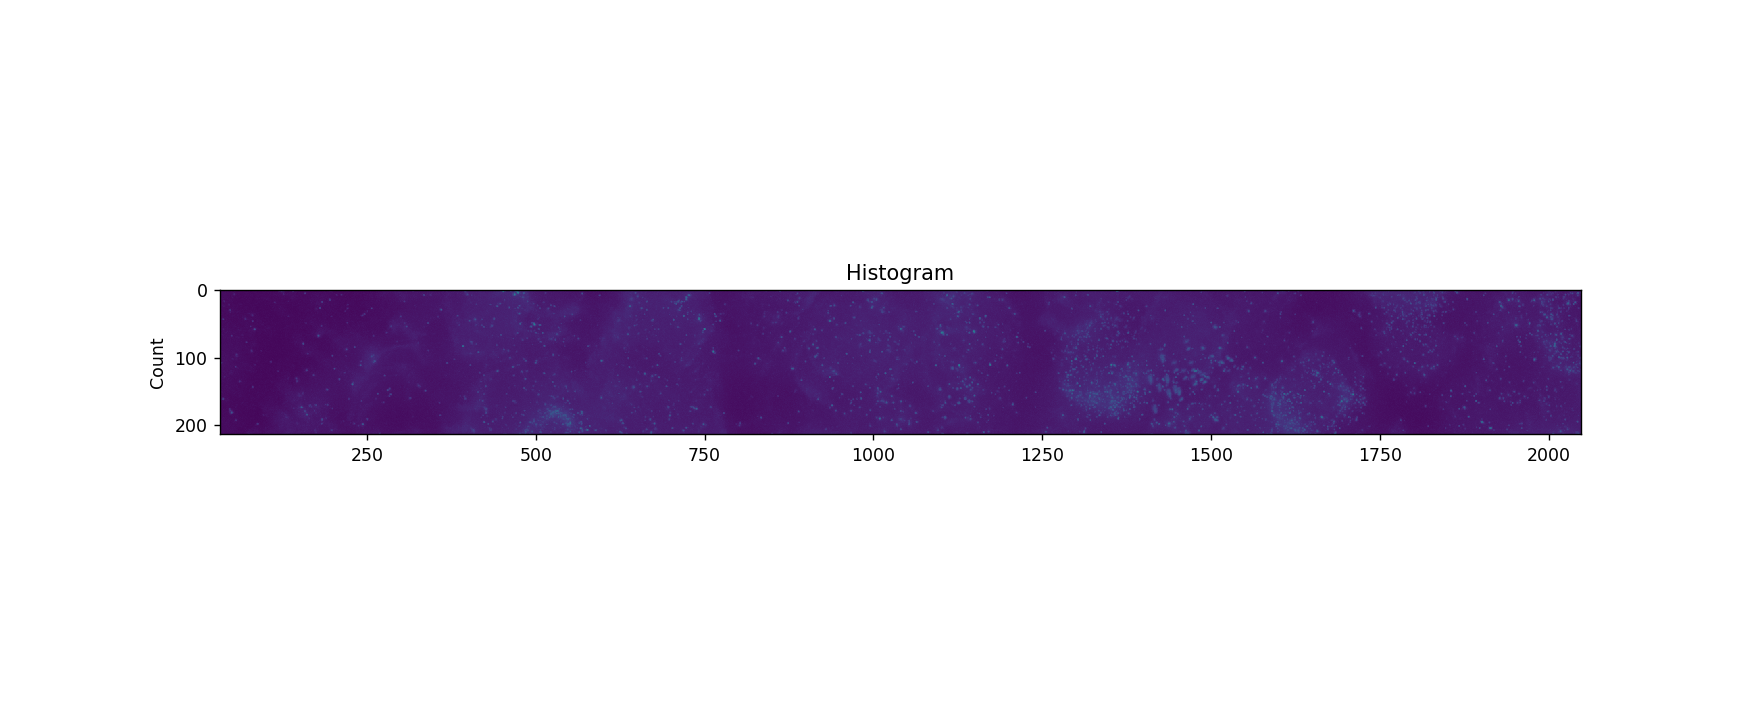

<IPython.core.display.Javascript object>


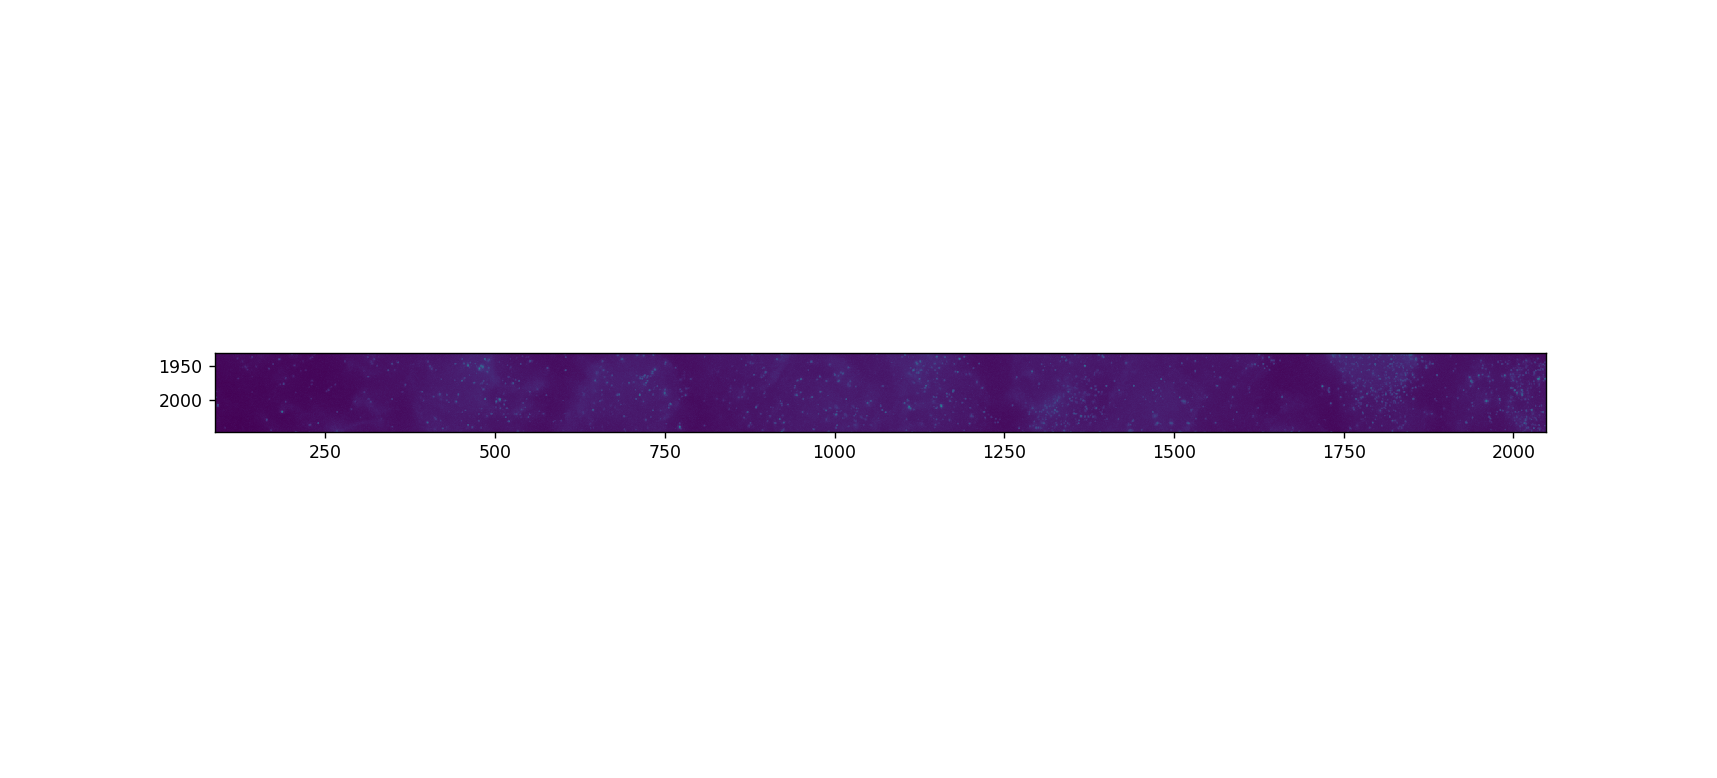

In [60]:
tarray0 =projection0._squeezed_numpy()
tarray1 =projection1._squeezed_numpy()
plt.figure()
plt.imshow(np.squeeze(tarray0[0,0,0,:,:]))
plt.figure()
plt.imshow(np.squeeze(tarray1[0,0,0,:,:]))

<IPython.core.display.Javascript object>


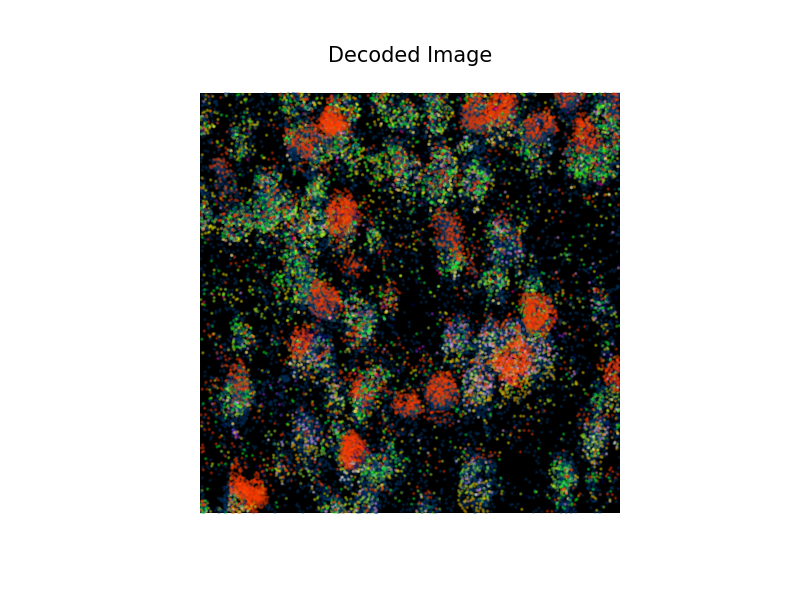

<IPython.core.display.Javascript object>


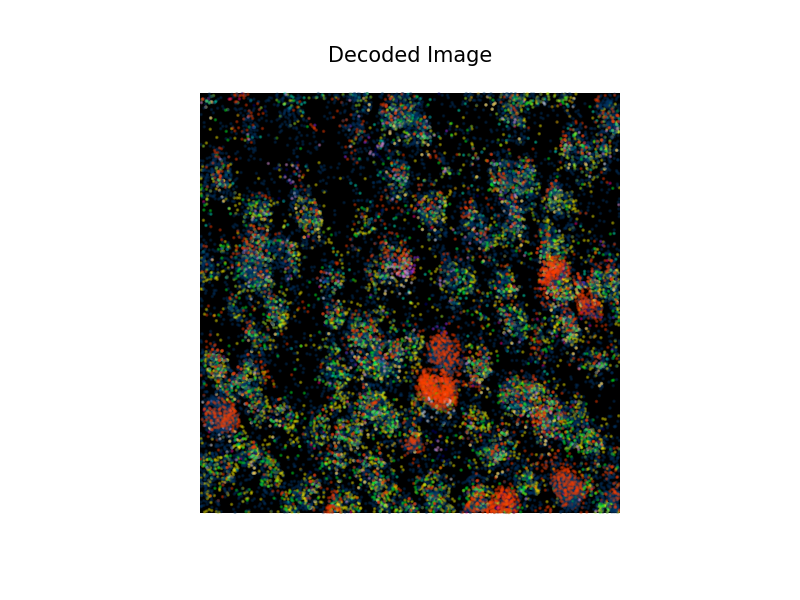

In [61]:
f=plt.figure()
ax  =plt.gca()
starfish.plot.decoded_spots(testRead, background_shape=[2048,2048], ax=ax, spots_kwargs={'alpha': 0.3, 'cmap': plt.cm.gist_ncar})
f=plt.figure()
# ax  =plt.gca()
starfish.plot.decoded_spots(testRead2, background_shape=[2048,2048],spots_kwargs={'alpha': 0.3, 'cmap': plt.cm.gist_ncar})
f.show()

In [80]:
c0x=f0[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.X)
c0y=f0[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.Y)
c1x=f1[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.X)
c1y=f1[FieldOfView.PRIMARY_IMAGES].coordinates({Indices.ROUND: 4, Indices.CH: 2, Indices.Z: 2}, Coordinates.Y)

In [84]:
print("===  x: ")

print(c0x[0])
print(c1x[0])
print(c0x[1]-c0x[0])
print(c1x[0]-c0x[0])
print((c1x[0]-c0x[0])/(c0x[1]-c0x[0]))

print("===  y: ")
print(c0y[0])
print(c1y[0])
print(c0y[1]-c0y[0])
print(c1y[0]-c0y[0])
print((c1y[0]-c0y[0])/(c0y[1]-c0y[0]))

===  x: 
-0.0015364591963589191
-0.0015369177563115954
0.00020480004604905844
-4.5855995267629623e-07
-0.002239061765476612
===  y: 
-0.0015133596025407314
-0.0017079281387850642
0.00020480004604905844
-0.0001945685362443328
-0.950041467264735


In [91]:
f0[FieldOfView.PRIMARY_IMAGES]._coordinates.values

array([[[[-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  0.0000000e+00,  3.0000001e-07],
         [-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  3.0000001e-07,  6.0000002e-07],
         [-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  6.0000002e-07,  8.9999997e-07],
         ...,
         [-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  9.2999999e-06,  9.6000003e-06],
         [-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  9.6000003e-06,  9.8999999e-06],
         [-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  9.8999999e-06,  1.0200000e-05]],

        [[-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  0.0000000e+00,  3.0000001e-07],
         [-1.5401419e-03, -1.3353419e-03, -1.5108568e-03,
          -1.3060567e-03,  3.0000001e-07,  6.0000002e-07],
         [-1.5401419e-03, -1.3353419e-03, -1.510

In [ ]:
# output_dir = "/home/brianl/mFISHrig2/rexp1_acq4_data/Mouse_smFISH/CZI_test/"
# input_dir = "/home/brianl/mFISHrig2/rexp1_acq4_data/Mouse_smFISH/CZI_AIBS-Boyden_Broad-Inhibitory_102318/"

# write_experiment_json(
#         output_dir,
#         77,
#         {
#             Indices.ROUND: 9,
#             Indices.CH: 3,
#             Indices.Z: 34,
#         },
#         {
#             'nuclei': {
#                 Indices.ROUND: 9,
#                 Indices.CH: 1,
#                 Indices.Z: 34,
#             },

#         },
#         primary_tile_fetcher=glad.AllenPrimaryTileFetcher(input_dir),
#         default_shape=SHAPE
#     )
